In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import pandas as pd
import numpy as np 

import create_model
import pickle
import time 

import random
import data_formatting


def decodeSent(sent):
    return [inv_map[i] for i in sent if i not in [0, -1]]

def validate(train):
    
    if train == True:
        
        model = train_model
        mode = 'TRAIN'
        
    else:
        mode = 'DEV'
        model = dev_model

    encoder, decoder, predicted = session.run([model.encoder_inputs, model.decoder_targets, model.decoder_pred_train])            

    print ('Current mode:%s' % mode)
    for i, (e_in, dt_targ, dt_pred) in enumerate(zip( encoder, decoder, predicted)):

        print('  sample {}:'.format(i + 1))
        #print('    enc input           > {}'.format(e_in))
        print('    enc input           > {}'.format(decodeSent(e_in)))

        #print('    dec input           > {}'.format(dt_targ))
        print('    dec input           > {}'.format(decodeSent(dt_targ)))

        #print('    dec train predicted > {}'.format(dt_pred))
        print('    dec train predicted > {}'.format(decodeSent(dt_pred)))

        if i >= 0: break

In [2]:
dataset = 'twitter'

#vocab_dict = pickle.load(open('../processed_data/word_dict_v02_twitter_py35_seq_length_4_15_sample_134241_full.pkl', 'rb'))
#df_all = pd.read_pickle('../processed_data/processed_data_v02_twitter_py35_seq_length_4_15_sample_134241_full.pkl')

#vocab_dict = pickle.load(open('../processed_data/word_dict_v02_twitter_py35_seq_length_3_19_sample_21946_lem.pkl', 'rb'))
#df_all = pd.read_pickle('../processed_data/processed_data_v02_twitter_py35_seq_length_3_19_sample_21946_lem.pkl')

vocab_dict = pickle.load(open('../processed_data/word_dict_v02_twitter_py35_seq_length_3_25_sample_1901567_full.pkl', 'rb'))
df_all = pd.read_pickle('../processed_data/processed_data_v02_twitter_py35_seq_length_3_25_sample_1901567_full.pkl')

In [4]:
np.asarray(df_all['alpha_Pair_1_encoding'].values[0][0], dtype=np.int32).dtype

dtype('int32')

In [5]:
df_all_train = df_all.sample(frac=0.97, random_state=1)

df_all_dev = df_all[df_all['Index'].isin(df_all_train['Index'].values) == False]

df_all_test = df_all_dev.sample(frac=0.10, random_state=1)

df_all_dev = df_all_dev[df_all_dev['Index'].isin(df_all_test['Index'].values) == False]

In [6]:
print (df_all.shape[0], df_all_train.shape[0],  df_all_dev.shape[0], df_all_test.shape[0], len(vocab_dict))

1901567 1844520 51342 5705 57740


In [7]:
train_data = data_formatting.prepare_train_batch(df_all_train['alpha_Pair_0_encoding'].values, 
                                                    df_all_train['alpha_Pair_1_encoding'].values)

dev_data = data_formatting.prepare_train_batch(df_all_dev['alpha_Pair_0_encoding'].values, 
                                                    df_all_dev['alpha_Pair_1_encoding'].values)

test_data = data_formatting.prepare_train_batch(df_all_test['alpha_Pair_0_encoding'].values, 
                                                    df_all_test['alpha_Pair_1_encoding'].values)

In [9]:
inv_map = {v: k for k, v in vocab_dict.items()}
inv_map[-1] = 'NULL'

In [10]:
train_model_params = {'n_cells':256, 'num_layers':2, 'embedding_size':1024, 
          'vocab_size':len(vocab_dict) + 1, 'minibatch_size':32, 'n_threads':128,
          'beam_width':10, 
          'encoder_input_keep':1, 'decoder_input_keep':1,
          'encoder_output_keep':1, 'decoder_output_keep':1,
         }

In [11]:
dev_model_params = {'n_cells':256, 'num_layers':2, 'embedding_size':1024, 
          'vocab_size':len(vocab_dict) + 1, 'minibatch_size':32, 'n_threads':128,
          'beam_width':10, 
          'encoder_input_keep':1, 'decoder_input_keep':1,
          'encoder_output_keep':1, 'decoder_output_keep':1,
         }

In [12]:
training_params = { 'vocab_lower':3, 'vocab_upper':train_model_params['vocab_size']-1, 
                    'n_epochs':5000000}

In [18]:
tf.reset_default_graph()

In [19]:
with tf.variable_scope('training_model'):
    
    train_model = create_model.Model(train_model_params, 'train', train_data)

with tf.variable_scope('training_model', reuse=True):

    dev_model = create_model.Model(dev_model_params, 'train', dev_data)    

In [ ]:
global_step = tf.Variable(0, trainable=False)

starter_learning_rate = tf.placeholder(tf.float32, shape=(), name='starter_learning_rate')

learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, \
                                   10000, 0.98, staircase=False)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train_op = optimizer.minimize(train_model.loss, global_step=global_step)

In [ ]:
print_interval = 100
save_interval = 1000

lr = 0.001

train_loss = []
dev_loss = []

train_accuracy = []
dev_accuracy = []

learning_rate = []

with tf.Session() as session:

    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    coord = tf.train.Coordinator()

    threads = tf.train.start_queue_runners(coord=coord)
    #saver.restore(session, 'chkpt/seq2seq_twitter_test_2-5001')


    for epoch in range(training_params['n_epochs']):

        start_time = time.time()

        session.run(train_op, feed_dict={'starter_learning_rate:0':lr})
        #session.run(train_op)

        if epoch % print_interval == 0: 

            print ('epoch:%d, global_step:%s, learning rate:%.3g' % 
                       (epoch, tf.train.global_step(session, global_step), 
                        session.run(optimizer._lr, feed_dict={'starter_learning_rate:0':lr})))

            train_minibatch_loss,  train_minibatch_accuracy = session.run([train_model.loss, train_model.accuracy], 
                                                                          feed_dict={'starter_learning_rate:0':lr})

            train_loss.append([tf.train.global_step(session, global_step), train_minibatch_loss])  
            train_accuracy.append([tf.train.global_step(session, global_step), train_minibatch_accuracy])  

            print ('training minibatch loss:%.6g' % (train_minibatch_loss))
            print ('training minibatch accuracy:%.6g' % (train_minibatch_accuracy))

            validate(train=True)

            dev_model_loss, dev_model_accuracy = session.run([dev_model.loss, dev_model.accuracy])            

            print ('dev minibatch loss:%.6g' %  (dev_model_loss))
            print ('dev minibatch accuracy:%.6g' %  (dev_model_accuracy))

            dev_loss.append([tf.train.global_step(session, global_step), dev_model_loss])

            dev_accuracy.append([tf.train.global_step(session, global_step), dev_model_accuracy])

            learning_rate.append([tf.train.global_step(session, global_step), 
                                  session.run(optimizer._lr, feed_dict={'starter_learning_rate:0':lr})])

            validate(train=False)

            print ('Epoch:%d finished, time:%.4g' % (epoch, time.time() - start_time))

        if (epoch % save_interval == 0):# & (epoch!=0): 

            saver.save(session, '../chkpt/seq2seq_twitter_testing', global_step = tf.train.global_step(session, global_step))

            print ('Session saved')

    coord.request_stop()
    coord.join(threads)

session.close()

In [15]:
session.close()

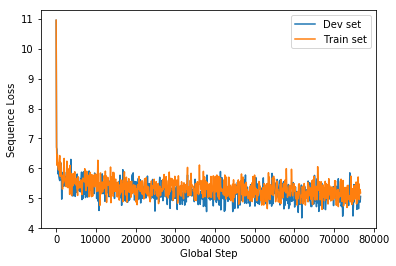

In [16]:
plt.plot(list(zip(*dev_loss))[0], list(zip(*dev_loss))[1], label='Dev set')
plt.plot(list(zip(*train_loss))[0], list(zip(*train_loss))[1], label='Train set')
plt.xlabel('Global Step')
plt.ylabel('Sequence Loss')
#plt.title('Seq2Seq Twitter Data')
#plt.title(' '.join(['%s:%d' % (i, j) for i,j in zip(model_params.keys(), model_params.values())]))
plt.legend(loc='best')
plt.show()

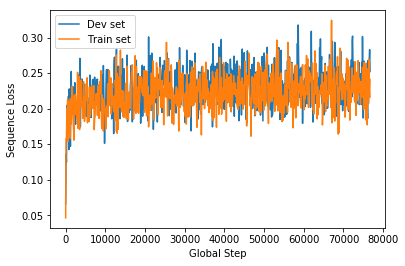

In [18]:
plt.plot(list(zip(*dev_accuracy))[0], list(zip(*dev_accuracy))[1], label='Dev set')
plt.plot(list(zip(*train_accuracy))[0], list(zip(*train_accuracy))[1], label='Train set')
plt.xlabel('Global Step')
plt.ylabel('Sequence Loss')
#plt.title('Seq2Seq Twitter Data')
#plt.title(' '.join(['%s:%d' % (i, j) for i,j in zip(model_params.keys(), model_params.values())]))
plt.legend(loc='best')
plt.show()

In [15]:
tf.reset_default_graph()

with tf.variable_scope('training_model'):

    inf_model = create_model.Model(dev_model_params, 'infer', test_data[:20])

In [20]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as session:
    
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    coord = tf.train.Coordinator()
   
    threads = tf.train.start_queue_runners(coord=coord)
    #saver.restore(session, 'd:\coding\seq2seq_2\seq2seq\chkpt\seq2seq_twitter_queue-1')
    saver.restore(session, '../chkpt/seq2seq_twitter_testing-1')
    
    #inf_out = session.run([inf_model.decoder_pred_decode, inf_model.decoder_pred_decode_prob], feed_dict_inf)
    inf_out = session.run([inf_model.encoder_inputs, inf_model.decoder_pred_decode],
            feed_dict = {'training_model/encoder_inputs:0':[[4,5,6,7]], 'training_model/encoder_inputs_length:0':[4]})
    
    encoder_input = inf_out[0]
    #decoder_target = inf_out[1]
    decoder_inference = inf_out[1]
    
    coord.request_stop()
    coord.join(threads)

    for idx, e_in in enumerate(encoder_input):
                
        print ('###%d###' % idx)
        
        print ('e_in', decodeSent(e_in))
        #print ('d_in', decodeSent(dt_in))        
        beam_inf = list(zip(*decoder_inference[idx]))
        for idx_inf, dt_inf in enumerate(beam_inf):

            print ('dt_inf', decodeSent(dt_inf))
            if idx_inf>1: break                

INFO:tensorflow:Restoring parameters from ../chkpt/seq2seq_twitter_testing-1


INFO:tensorflow:Restoring parameters from ../chkpt/seq2seq_twitter_testing-1


###0###
e_in ['rothman', 'readership', 'mix', 'dod']
dt_inf ['crestfallen', 'shenandoah', 'uofm', 'shenandoah', 'shenandoah', 'shenandoah', 'shenandoah']
dt_inf ['crestfallen', 'shenandoah', 'shenandoah', 'uofm', 'shenandoah', 'shenandoah', 'shenandoah']
dt_inf ['crestfallen', 'shenandoah', 'shenandoah', 'shenandoah', 'shenandoah', 'shenandoah', 'shenandoah']
